In [36]:
import pandas as pd
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import optuna


### Carregar os dados

In [37]:
df_diabetes = pd.read_csv("diabetes.csv")

In [38]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   glicemia          995 non-null    int64
 1   pressao_arterial  995 non-null    int64
 2   diabetes          995 non-null    int64
dtypes: int64(3)
memory usage: 23.4 KB


In [39]:
df_diabetes.head(5)

,glicemia,pressao_arterial,diabetes
0,40,85,0
1,40,92,0
2,45,63,1
3,45,80,0
4,40,73,1


In [40]:
df_diabetes.tail(5)

,glicemia,pressao_arterial,diabetes
990,45,87,0
991,40,83,0
992,40,83,0
993,40,60,1
994,45,82,0


In [41]:
df_diabetes["diabetes"].unique()

array([0, 1])

In [42]:
df_diabetes["diabetes"].value_counts()

diabetes
1    498
0    497
Name: count, dtype: int64

In [43]:
df_diabetes["diabetes"].value_counts(normalize=True)

diabetes
1    0.500503
0    0.499497
Name: proportion, dtype: float64

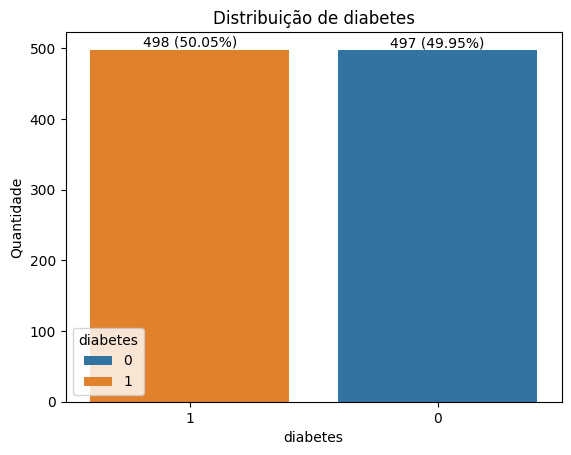

In [44]:
# Gráfico de barras da variável diabetes
total = len(df_diabetes)

ax = sns.countplot(
    data=df_diabetes,
    x="diabetes",
    hue="diabetes",
    order=df_diabetes["diabetes"].value_counts().index
)

for container in ax.containers:
    ax.bar_label(container, labels=[f"{int(v)} ({round((v / total) * 100, 2)}%)" for v in container.datavalues])

plt.title("Distribuição de diabetes")
plt.ylabel('Quantidade')
plt.show()

Text(0, 0.5, 'Frequência')

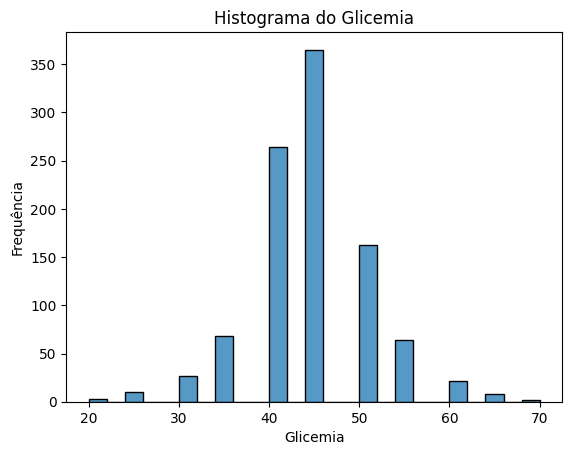

In [45]:
# Histrograma da variável glicemia
sns.histplot(data=df_diabetes, x="glicemia", kde=False)

plt.title("Histograma do Glicemia")
plt.xlabel("Glicemia")
plt.ylabel("Frequência")

<Axes: ylabel='glicemia'>

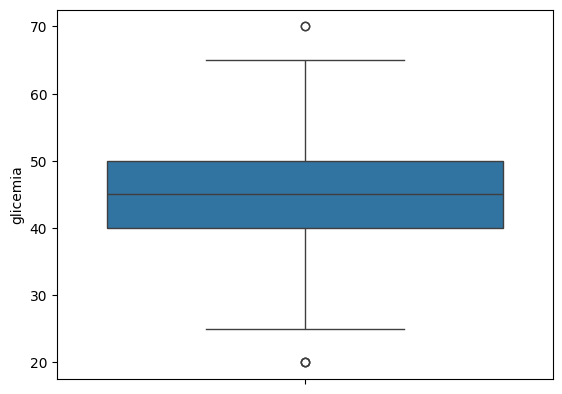

In [46]:
# Boxplot da variável glicemia
sns.boxplot(data=df_diabetes, y="glicemia")

Text(0, 0.5, 'Frequência')

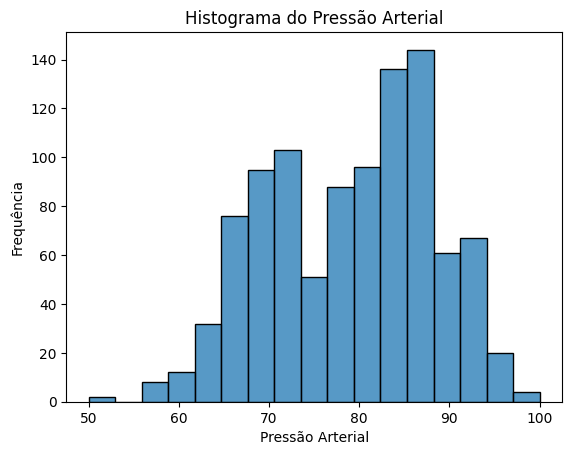

In [47]:
# Histrograma da variável pressão arterial
sns.histplot(data=df_diabetes, x="pressao_arterial", kde=False)

plt.title("Histograma do Pressão Arterial")
plt.xlabel("Pressão Arterial")
plt.ylabel("Frequência")

<Axes: ylabel='pressao_arterial'>

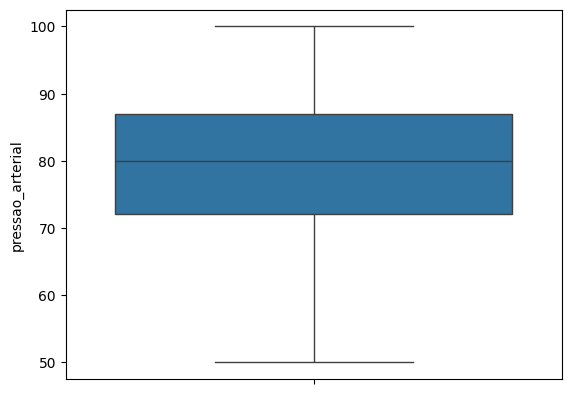

In [48]:
# Boxplot da variável pressão arterial
sns.boxplot(data=df_diabetes, y="pressao_arterial")

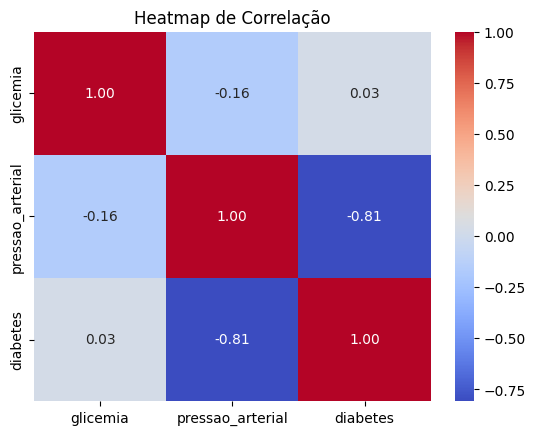

In [49]:
# Heatmap e matriz de correlação
corr = df_diabetes.corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap de Correlação")
plt.show()

In [50]:
stat, p_value = shapiro(df_diabetes["glicemia"])
print(f"Estatística do teste: {stat}, p-value: {p_value}")

Estatística do teste: 0.9321769909426705, p-value: 7.851797454813074e-21


In [51]:
stat, p_value = shapiro(df_diabetes["pressao_arterial"])
print(f"Estatística do teste: {stat}, p-value: {p_value}")

Estatística do teste: 0.9708248310894475, p-value: 3.022068208530379e-13


As duas variáveis independentes rejeitam a hipótese de elas seguem uma distribuição normal, pois os seus valores de p-value no teste do shapiro são menores que 0,05. Existe um associação negativa entre as variáveis pressão arterial e diabetes. Já a associação entre a glicemia e diabetes não é tão forte.

### Modelo Naive-Bayes

In [52]:
# Separar features da target
X = df_diabetes.drop(columns=["diabetes"])
y = df_diabetes["diabetes"]


In [53]:
# Dividir base de dados em amostras de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=51)

In [54]:
# Otimização para selecionar features
def f_obj(trial):
    blood_glucose = trial.suggest_categorical("blood_glucose", [True, False])
    blood_pressure = trial.suggest_categorical("blood_pressure", [True, False])

    selected_features = []
    if blood_glucose:
        selected_features.append("glicemia")
    if blood_pressure:
        selected_features.append("pressao_arterial")
    
    if not selected_features:
        return 0.0
    
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    model = GaussianNB()
    model.fit(X_train_selected, y_train)


    y_pred = model.predict(X_test_selected)
    precision = precision_score(y_test, y_pred, zero_division=1)

    return precision

study = optuna.create_study(direction="maximize")
study.optimize(f_obj, n_trials=50)

print(f"Melhor precisão: {study.best_value}")
print(f"Melhores parâmetros: {study.best_params}")

[I 2025-09-29 09:11:24,391] A new study created in memory with name: no-name-28e9492d-70fe-414c-b147-f76a19ffdea9
[I 2025-09-29 09:11:24,395] Trial 0 finished with value: 0.9545454545454546 and parameters: {'blood_glucose': True, 'blood_pressure': True}. Best is trial 0 with value: 0.9545454545454546.
[I 2025-09-29 09:11:24,396] Trial 1 finished with value: 0.0 and parameters: {'blood_glucose': False, 'blood_pressure': False}. Best is trial 0 with value: 0.9545454545454546.
[I 2025-09-29 09:11:24,397] Trial 2 finished with value: 0.0 and parameters: {'blood_glucose': False, 'blood_pressure': False}. Best is trial 0 with value: 0.9545454545454546.
[I 2025-09-29 09:11:24,400] Trial 3 finished with value: 0.9545454545454546 and parameters: {'blood_glucose': True, 'blood_pressure': True}. Best is trial 0 with value: 0.9545454545454546.
[I 2025-09-29 09:11:24,400] Trial 4 finished with value: 0.0 and parameters: {'blood_glucose': False, 'blood_pressure': False}. Best is trial 0 with value: 

Melhor precisão: 0.9655172413793104
Melhores parâmetros: {'blood_glucose': False, 'blood_pressure': True}


In [55]:
# Modelo final
selected_best_features = []
if study.best_params["blood_glucose"]:
    selected_best_features.append("glicemia")
if study.best_params["blood_pressure"]:
    selected_best_features.append("pressao_arterial")

X_train_best = X_train[selected_best_features]
X_test_best = X_test[selected_best_features]

optimized_model = GaussianNB()
optimized_model.fit(X_train_best, y_train)

y_pred_best = optimized_model.predict(X_test_best)
best_precision = precision_score(y_test, y_pred_best, zero_division=1)

In [56]:
# Mostrar relatório
report = classification_report(y_test, y_pred_best)
print("\nRelatório de Classificação: \n", report)

matrix = confusion_matrix(y_test, y_pred_best)
print("\nMatriz de Confusão: \n", matrix)

score = accuracy_score(y_test, y_pred_best)
print("\nAcurácia: \n", score)


Relatório de Classificação: 
               precision    recall  f1-score   support

           0       0.89      0.96      0.93       142
           1       0.97      0.89      0.93       157

    accuracy                           0.93       299
   macro avg       0.93      0.93      0.93       299
weighted avg       0.93      0.93      0.93       299


Matriz de Confusão: 
 [[137   5]
 [ 17 140]]

Acurácia: 
 0.9264214046822743


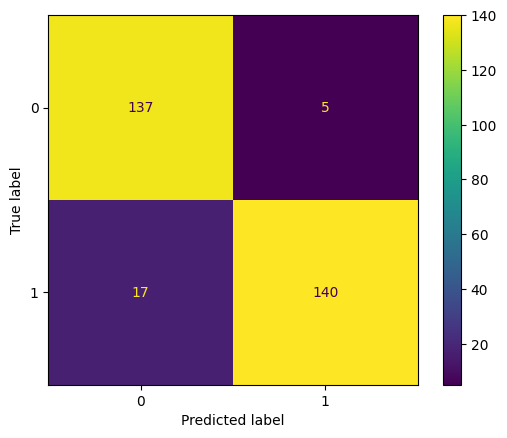

In [57]:
# Mostrar matriz de confusão
confusion_matrix_model_baseline = confusion_matrix(y_test, y_pred_best)
disp_model_baseline = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_model_baseline)
disp_model_baseline.plot()

Análise:

Na análise exploratória de dados ficou claro que a variável glicemia possui uma associação fraca com a variável target diabetes, equanto que a variável pressão arterial já possui uma associação forte. Pornanto, ao rodar a otimização para selecionar as features mais relevantes para o modelo, a característica pressão arterial foi selecionada e a glicemia não foi selecionada. O valor de precisão do modelo final é igual a aproximadamente 97%. Ao avaliar esta precisão percebe-se que o modelo performou bem na classificação de diabetes.

Relatório:

- 97% das diabetes classificadas como positivas foram classificadas corretamente
- 91% das diabetes classificadas como negativas foram classificadas corretamente
- 93% de acerto nas classificações de diabetes
- 89% das diabetes foram identificadas pelo modelo
- 93% de f1-score refletinfo o equilíbrio entre recall e precisão

Matriz de confusão:

- Verdadeiros Positivos (diabetes positivas corretamente identificadas) = 140
- Verdadeiros Negativos (diabetes negativas corretamente identificadas) = 137
- Falsos Positivos (diabetes positivas classificadas incorretamente) = 5
- Falsos Negativos (diabetes negativas classificadas incorretamente) = 17